In [0]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import tensorflow_hub as hub

In [0]:
latent_dim = 512
#Image generator based on tensorflow reimplementation of Progressive GANs[1
# Display multiple images in the same figure.
#The original model has been trained on a GPU for 636,801 steps with batch size 16
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()
  
  


In [0]:
# Install TF-Hub.
!pip -q install tensorflow-hub
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image

In [0]:
import math
import os
import hashlib
from urllib.request import urlretrieve
import zipfile
import gzip
import shutil

import numpy as np
from PIL import Image
from tqdm import tqdm


def _read32(bytestream):
    """
    Read 32-bit integer from bytesteam
    :param bytestream: A bytestream
    :return: 32-bit integer
    """
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)


def _ungzip(save_path, extract_path, database_name, _):
    """
    Unzip a gzip file and extract it to extract_path
    :param save_path: The path of the gzip files
    :param extract_path: The location to extract the data to
    :param database_name: Name of database
    :param _: HACK - Used to have to same interface as _unzip
    """
    # Get data from save_path
    with open(save_path, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            magic = _read32(bytestream)
            if magic != 2051:
                raise ValueError('Invalid magic number {} in file: {}'.format(magic, f.name))
            num_images = _read32(bytestream)
            rows = _read32(bytestream)
            cols = _read32(bytestream)
            buf = bytestream.read(rows * cols * num_images)
            data = np.frombuffer(buf, dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)

    # Save data to extract_path
    for image_i, image in enumerate(
            tqdm(data, unit='File', unit_scale=True, miniters=1, desc='Extracting {}'.format(database_name))):
        Image.fromarray(image, 'L').save(os.path.join(extract_path, 'image_{}.jpg'.format(image_i)))


def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    if image.size != (width, height):  # HACK - Check if image is from the CELEBA dataset
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))


def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch


def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im


def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_CELEBA_NAME = 'celeba'
    DATASET_MNIST_NAME = 'mnist'

    if database_name == DATASET_CELEBA_NAME:
        url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
        hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
        extract_path = os.path.join(data_path, 'img_align_celeba')
        save_path = os.path.join(data_path, 'celeba.zip')
        extract_fn = _unzip
  
    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    # Remove compressed data
    os.remove(save_path)


class Dataset(object):
    """
    Dataset
    """
    def __init__(self, dataset_name, data_files):
        """
        Initalize the class
        :param dataset_name: Database name
        :param data_files: List of files in the database
        """
        DATASET_CELEBA_NAME = 'celeba'
        DATASET_MNIST_NAME = 'mnist'
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28

        if dataset_name == DATASET_CELEBA_NAME:
            self.image_mode = 'RGB'
            image_channels = 3

        elif dataset_name == DATASET_MNIST_NAME:
            self.image_mode = 'L'
            image_channels = 1

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5


class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [6]:
datadir='/content/grive/My drive'
download_extract('celeba', datadir)



Extracting celeba...


In [0]:
import os
from glob import glob
import numpy as np
from matplotlib import pyplot
show_n_images = 25


In [37]:
generate = hub.Module("https://tfhub.dev/google/progan-128/1")
images = generate(tf.random_normal([20, 512]))

with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      interpolated_images_out = session.run(images)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
def conv2D(x,W):
  return tf.nn.conv2d(input=x,filter=W,strides=[1,1,1,1],padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


In [0]:
def discreminator(x_image,reuse=False):
  with tf.variable_scope('discreminator') as scope:
    if (reuse):
      tf.get_variable_scope().reuse_variables()
      
    w_conv1=tf.get_variable('d_wconv1',[3,3,3,64],initializer=tf.truncated_normal_initializer(stddev=0.02))
    #The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels
    b_conv1=tf.get_variable('d_bconv1',[64],initializer=tf.constant_initializer(0))
    h_conv1=tf.nn.leaky_relu(conv2D(x_image,w_conv1)+b_conv1)
    h_pool1=avg_pool_2x2(h_conv1)
    #relu is a max(0,x) function. If there is any input -ve on the input(eg: black in image), it sets to 0
    #h_pool1 pools the avegae of 4 variables to one for better generalization of the image
    
    #second layer
    
    w_conv2=tf.get_variable('d_wconv2',[3,3,64,128],initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_conv2=tf.get_variable('d_bconv2',[128],initializer=tf.constant_initializer(0))
    h_conv2=tf.nn.leaky_relu(conv2D(h_pool1,w_conv2)+b_conv2)
    h_pool2=avg_pool_2x2(h_conv2)
    
    # third layer
    
    w_conv3=tf.get_variable('d_wconv3',[3,3,128,256],initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_conv3=tf.get_variable('d_bconv3',[256],initializer=tf.constant_initializer(0))
    h_conv3=tf.nn.leaky_relu(conv2D(h_pool2,w_conv3)+b_conv3)
    h_pool3=avg_pool_2x2(h_conv3)
    conv4_bn = tf.layers.batch_normalization(h_pool3)
    
    flat=tf.contrib.layers.flatten(conv4_bn)
    
    
    #first fully connected layer
    flat = tf.nn.dropout(flat, 0.4)
    
    
    
    
    w_fc1=tf.get_variable('d_wfc1',[8 * 8 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_fc1=tf.get_variable('d_bfc1',[32],initializer=tf.constant_initializer(0))
    h_pool2_flat= tf.reshape(flat,[-1, 8*8*16])
    h_fc1=tf.nn.leaky_relu(tf.matmul(h_pool2_flat,w_fc1)+b_fc1)
    
    
    w_fc2 = tf.get_variable('d_wfc2', [32,1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))
    
    
    y_conv=tf.matmul(h_fc1,w_fc2)+b_fc2
    
    
   
  return y_conv
    
    

In [0]:
def generator(z,batch_size,z_dim,reuse=False):
  with tf.variable_scope('generator') as scope:
    if (reuse):
      tf.get_variable_scope().reuse_variables()
      
    g_dim=64
    c_dim=3
    s=28
    
    
    s2,s4,s8,s16=int(s/2),int(s/4),int(s/8),int(s/16)
    h0=tf.reshape(z,[batch_size,s16+1,s16+1,25])
    h0=tf.nn.leaky_relu(h0)
    
    #First deconv layer
    
    output1_shape=[batch_size,s8,s8,g_dim*4]
    w_conv1=tf.get_variable('g_wconv1',[5,5,output1_shape[-1],int(h0.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv1=tf.get_variable('g_bconv1',[output1_shape[-1]],initializer=tf.constant_initializer(.1))
    h_conv1=tf.nn.conv2d_transpose(h0,w_conv1,output_shape=output1_shape,strides=[1,2,2,1],padding='SAME')+b_conv1
    h_conv1=tf.contrib.layers.batch_norm(inputs=h_conv1,center=True,scale=True,is_training=True,scope='g_bn1')
    h_conv1=tf.nn.leaky_relu(h_conv1)
    #Dimensions of H_conv1 = batch_size x 3 x 3 x 256
    
    
    output2_shape=[batch_size,s4-1,s4-1,g_dim*2]
    w_conv2=tf.get_variable('g_wconv2',[5,5,output2_shape[-1],int(h_conv1.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    b_conv2=tf.get_variable('g_bconv2',[output2_shape[-1]],initializer=tf.constant_initializer(.1))
    h_conv2=tf.nn.conv2d_transpose(h_conv1,w_conv2,output_shape=output2_shape,strides=[1,2,2,1],padding='SAME')+b_conv2
    h_conv2=tf.contrib.layers.batch_norm(inputs=h_conv2,center=True,scale=True,is_training=True,scope='g_bn2')
    h_conv2=tf.nn.leaky_relu(h_conv2)
    #Dimensions of H_conv2 = batch_size x 6 x 6 x 128
    
    
    output3_shape=[batch_size,s2-2,s2-2,g_dim*1]
    w_conv3=tf.get_variable('g_wconv3',[5,5,output3_shape[-1],int(h_conv2.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
  
    
    b_conv3=tf.get_variable('g_bconv3',[output3_shape[-1]],initializer=tf.constant_initializer(.1))
    h_conv3=tf.nn.conv2d_transpose(h_conv2,w_conv3,output_shape=output3_shape,strides=[1,2,2,1],padding='SAME')+b_conv3
    h_conv3=tf.contrib.layers.batch_norm(inputs=h_conv3,center=True,scale=True,is_training=True,scope='g_bn3')
    h_conv3=tf.nn.leaky_relu(h_conv3)
    ##Dimensions of H_conv3 = batch_size x 12 x 12 x 64
    
    
    output4_shape=[batch_size,s,s,c_dim]
    w_conv4=tf.get_variable('g_wconv4',[5,5,output4_shape[-1],int(h_conv3.get_shape()[-1])],initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    b_conv4=tf.get_variable('g_bconv4',[output4_shape[-1]],initializer=tf.constant_initializer(.1))
    h_conv4=tf.nn.conv2d_transpose(h_conv3,w_conv4,output_shape=output4_shape,strides=[1,2,2,1],padding='VALID')+b_conv4
    h_conv4=tf.contrib.layers.batch_norm(inputs=h_conv4,center=True,scale=True,is_training=True,scope='g_bn4')
    h_conv4=tf.nn.tanh(h_conv4)
    
  return h_conv4
    
    
                            
    
    
    
     

In [11]:
#NameError: name 'glob' is not defined
batch_size=32
z_dimensions=100
tf.reset_default_graph()
sess=tf.Session()

x_placeholder=tf.placeholder("float",shape=[None,28,28,3])
z_placeholder=tf.placeholder(tf.float32,shape=[None,z_dimensions])

Dx=discreminator(x_placeholder)
print(Dx)

Gz=generator(z_placeholder,batch_size,z_dimensions)
Dg=discreminator(Gz,reuse=True)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("discreminator/add_4:0", shape=(?, 1), dtype=float32)


In [0]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]
adam = tf.train.AdamOptimizer(learning_rate=0.0001)
trainerD = adam.minimize(d_loss, var_list=d_vars)
adam1=tf.train.AdamOptimizer()
trainerG = adam1.minimize(g_loss, var_list=g_vars)


In [0]:
import time

In [0]:
def show_generator_output(sess,n_images):
  
  sample_image = generator(z_placeholder, 1, z_dimensions, reuse=True)
  z_batch = np.random.normal(-1, 1, size=[n_images, z_dimensions])
  samples=(sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
  pyplot.imshow(images_square_grid(samples, 'RGB'))
  
  
  

In [0]:
def next_batch(num,data):
  idx=np.arange(0,len(data))
  np.random.shuffle(idx)
  idx=idx[:num]
  data_shuffle=[data[i] for i in idx]
  
  return np.asarray(data_shuffle)

In [0]:
celeba_dataset = Dataset('celeba', glob(os.path.join(datadir, 'img_align_celeba/*.jpg')))
#celeba_dataset = Dataset('celeba', glob(os.path.join(datadir, 'img_align_celeba/*.jpg')))
batches=celeba_dataset.get_batches

In [0]:
dLossList=[]
gLossList=[]

In [20]:
steps = 0
sess.run(tf.global_variables_initializer())
batch_size = 32 #Size of image batch to apply at each iteration.
epoch=100
startTime=time.time()
for i in range(epoch):
    for k in batches(batch_size):
      steps+=1
      z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
      _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:k}) #Update the discriminator
      _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator
      if steps%100==0:
        dLossList.append(dLoss)
        gLossList.append(gLoss)
        endTime=time.time()-startTime
        print(dLoss,gLoss)
        startTime=time.time()
        
    print("epoch",i)
      

1.2034616 0.8820151
0.7238839 1.1493815
1.1843579 1.2881403
1.2426926 0.78797257
1.3009677 0.84170425
1.1201248 0.87823105
1.3344216 0.8124574
1.3087175 0.84251046
1.371945 0.8298458
1.2614701 0.81331
1.380325 0.7741966
1.3321257 0.7237283
1.4848317 0.7562195
1.3752729 0.76206225
1.3375208 0.7560977
1.2454476 0.76633924
1.3626683 0.6848601
1.236974 0.615505
1.3752913 0.83115196
1.3912251 0.8356557
1.3647774 0.713021
1.4046412 0.69010794
1.3377459 0.62429297
1.3321536 0.6362225
1.3554974 0.79255366
1.378181 0.69012237
1.394717 0.7331526
1.030558 0.97876126
1.2857757 0.8733666
1.310095 0.6925291
1.1845356 0.7080451
1.3599241 0.80335855
0.8692113 0.8334953
1.4990072 1.128372
1.0019277 0.8747072
0.9133191 0.8207952
0.9284362 0.79347575
1.2511564 0.8935182
0.97962683 0.90208817
0.85579073 1.2104394
1.3232358 1.4728702
0.97472626 1.4213059
0.5009743 1.3102033
0.6576035 1.2501855
0.71159065 1.7281386
0.65557516 1.4515667
1.225816 1.3930947
1.1553009 1.1500833
0.918137 0.98163056
0.676285 1.34

KeyboardInterrupt: ignored

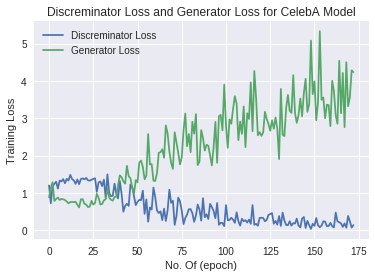

In [21]:
plt.plot(dLossList)
plt.plot(gLossList)
plt.title('Discreminator Loss and Generator Loss for CelebA Model')
plt.xlabel('No. Of (epoch)')
plt.ylabel('Training Loss')
plt.gca().legend(('Discreminator Loss','Generator Loss'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


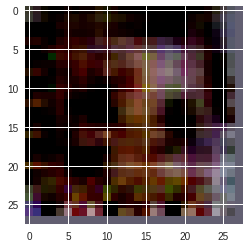

In [22]:
sample_image = generator(z_placeholder, 1, z_dimensions, reuse=True)
z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/progan-128/1'.
INFO:tensorflow:Downloaded https://tfhub.dev/google/progan-128/1, Total size: 87.58MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/progan-128/1'.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


IndexError: ignored

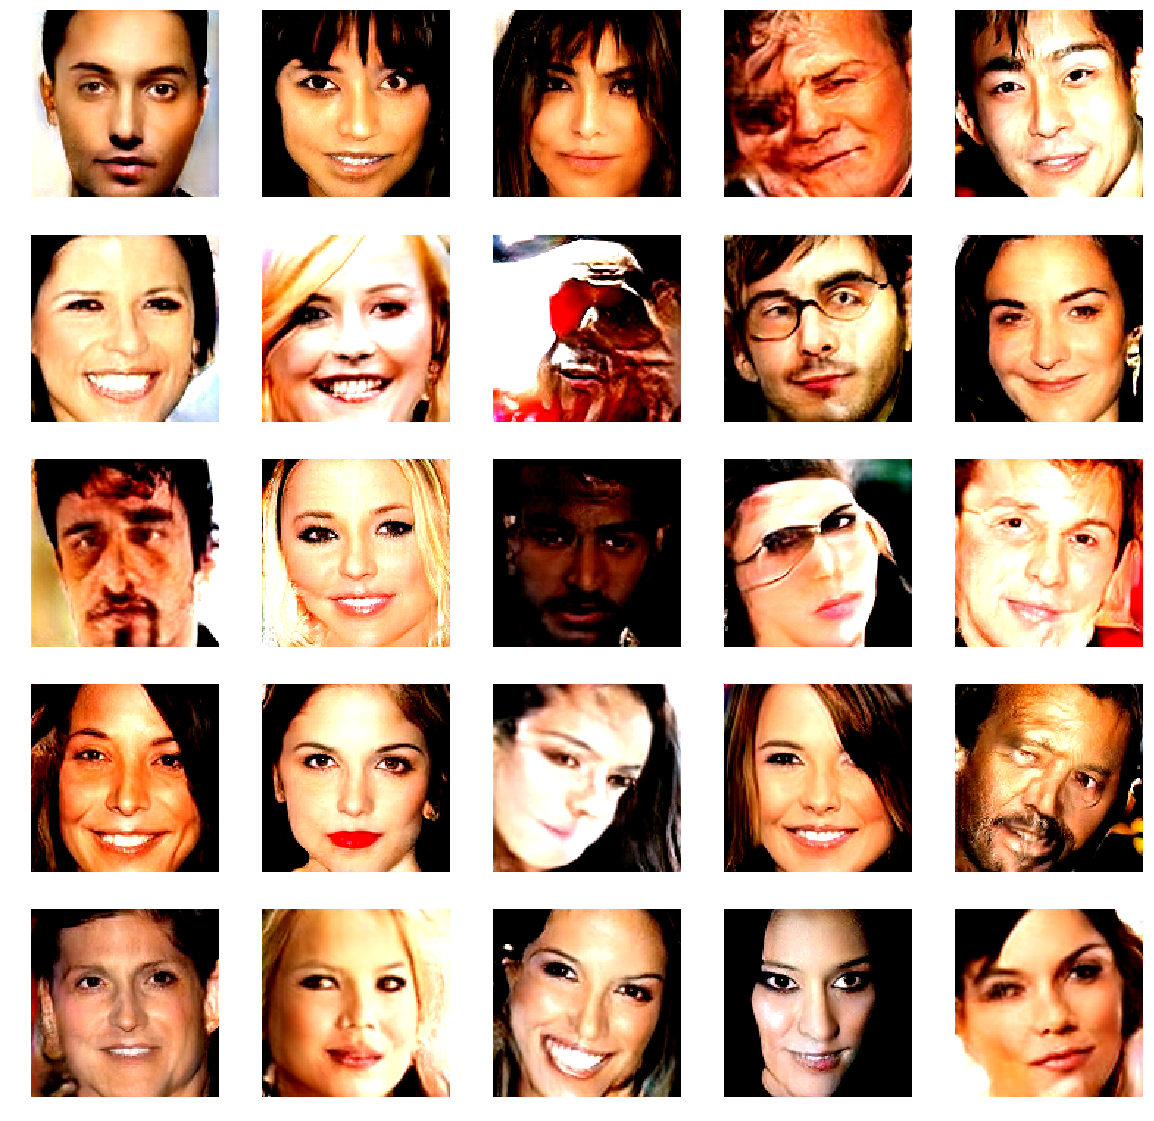

In [38]:
display_images(interpolated_images_out)